# Code for Chart Generation

## Imports

In [ ]:
import scanpy as sc
import os
import copy
import pandas as pd
import seaborn as sns
import pyviper
import warnings
import matplotlib
from scipy.stats import norm
import matplotlib.pyplot as plt

## These lines are to fix saving PDF with text recognizible by Adobe Illustrator
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="scanpy")
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()

my_random_seed = 666
n_cells_to_subsample = 3e3
n_cores = 1

sc.settings.n_jobs = int(n_cores)
sc.settings.set_figure_params(dpi=80,vector_friendly=False)

In [ ]:
# Load in data
base = "/shares/vasciaveo_lab/data/nepc_organoid_project/new_data"
vp_data_path = os.path.join(base, "pyviper_h5ad_outputs/prot_act_concatenated.h5ad")
vp_data = sc.read_h5ad(vp_data_path)

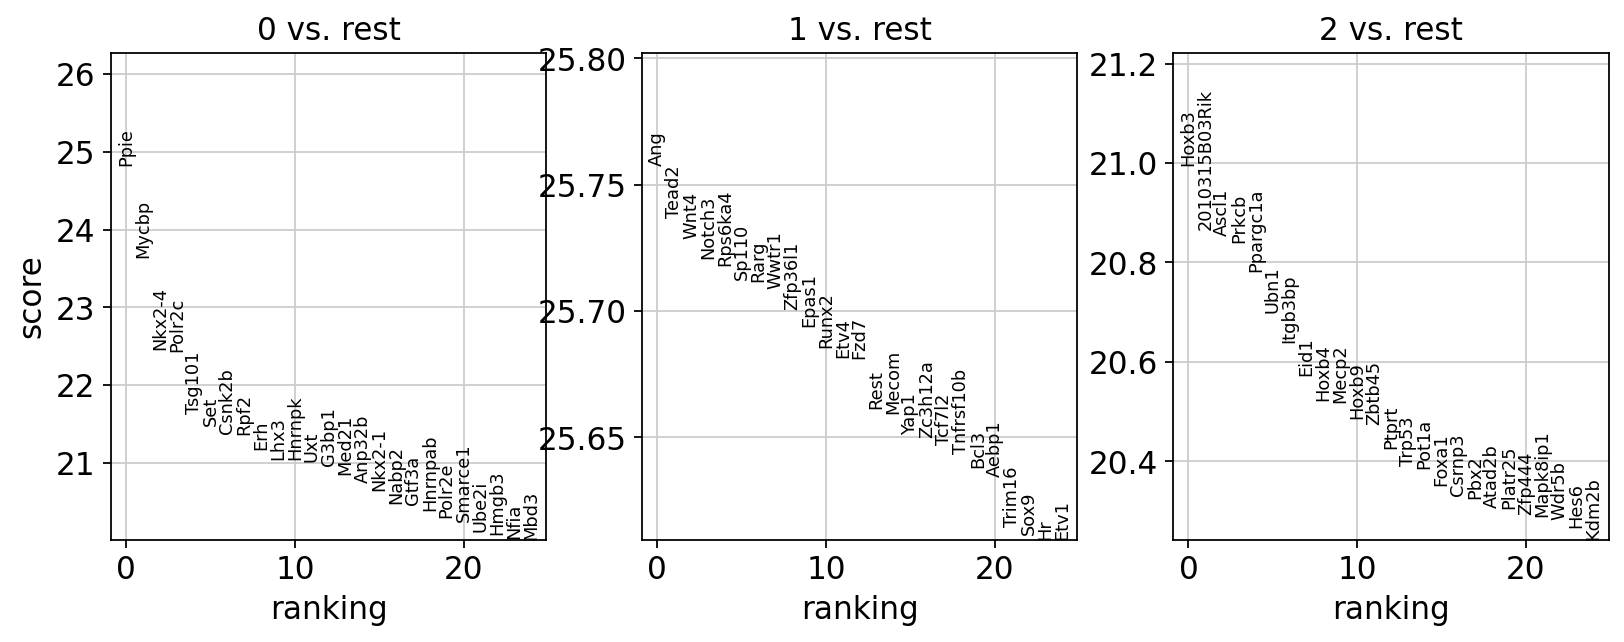

In [3]:
# Get subsampled data for analysis
vp_data_sub = sc.pp.sample(vp_data, n=1000 , rng=my_random_seed , copy=True) # it returns the subsampled adata
sc.tl.rank_genes_groups(vp_data_sub,
                        layer='mLog10' , 
                        groupby='leiden_pas' , method="wilcoxon" , corr_method="bonferroni")
sc.pl.rank_genes_groups(vp_data_sub, n_genes=25, sharey=False )

In [ ]:
# Get gene group rankings
pd.DataFrame(vp_data_sub.uns['rank_genes_groups']['names']).head(10)
result = vp_data_sub.uns['rank_genes_groups']
groups = result['names'].dtype.names

top_markers_proteins_df = pd.DataFrame(
    {group + '_' + key[:1]: result[key][group]
    for group in groups for key in ['names', 'pvals_adj','logfoldchanges']})

print("Injecting Wilcoxon over 1000 cells into main data object vp_data")
vp_data.uns['rank_genes_groups'] = vp_data_sub.uns['rank_genes_groups']

Injecting Wilcoxon over 1000 cells into main data object vp_data


In [ ]:
cluster_markers = {
    '1': {'Ar','Yap1','Wwtr1','Vim','Runx2'},        
    '2': {'Ppie','Set','Ptma','Atf4'},
    '3': {'Ascl1','Insm1','Chga','Nsd2','Hoxb3','Hoxb4'},
}
marker_matches = sc.tl.marker_gene_overlap(vp_data, cluster_markers)
marker_matches

0    1    2
1  0.0  3.0  0.0
2  4.0  0.0  0.0
3  0.0  0.0  4.0

In [6]:
vp_data.rename_categories('leiden_pas', marker_matches.idxmax())

/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/anndata/_core/anndata.py:1093: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  self.uns[k1][k2].dtype.names = categories


In [7]:
print("Running PAGA ...")
sc.tl.paga(vp_data,groups="leiden_pas")
sc.pl.paga(vp_data, plot=False,random_state=my_random_seed)

print("Running UMAP Analysis initialized with PAGA ...")
sc.tl.umap(vp_data, n_components=3 , random_state=my_random_seed, init_pos='paga')

Running PAGA ...
Running UMAP Analysis initialized with PAGA ...


In [8]:
print("Re-Running KNN for DiffMap ...")
sc.pp.neighbors(vp_data, n_neighbors=15, n_pcs=10, 
                use_rep="X_pca_harmony", 
                key_added="knn_for_diffmap",
                random_state=my_random_seed)

print("Running Diffusion Map Analysis ...")
sc.tl.diffmap(vp_data, 
              neighbors_key = "knn_for_diffmap",
              random_state=my_random_seed)

# Bug Fix for Diffmap
vp_data.obsm["X_diffmap_"] = vp_data.obsm["X_diffmap"][:, 1:] 
vp_data.obsm["X_diffmap"] = vp_data.obsm["X_diffmap_"]

Re-Running KNN for DiffMap ...
Running Diffusion Map Analysis ...


In [9]:
vp_data.obs['leiden_pas'] = vp_data.obs['leiden_pas'].cat.reorder_categories(['1', '2', '3'], ordered=True) 

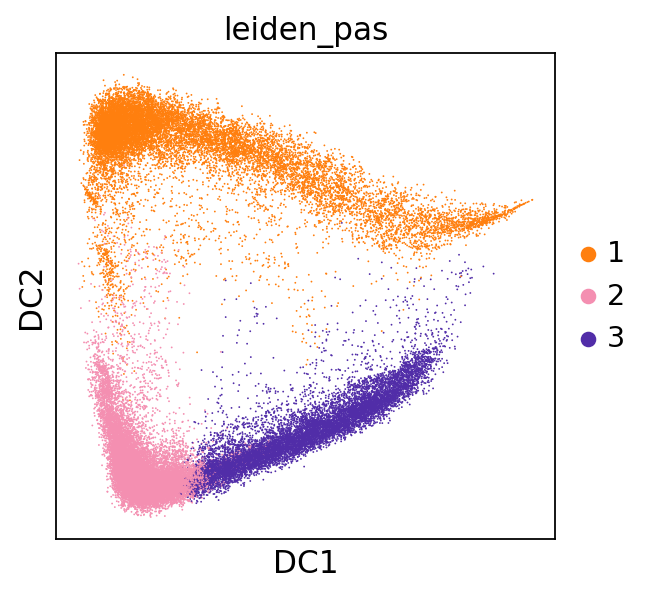

In [ ]:
# Plot the DiffMap
paper_color_palette = ["#FF7F0E","#F48FB1","#512DA8"]
sns.set_palette(paper_color_palette)
sc.pl.diffmap(vp_data, color=["leiden_pas"], palette=paper_color_palette)

NPPO-1


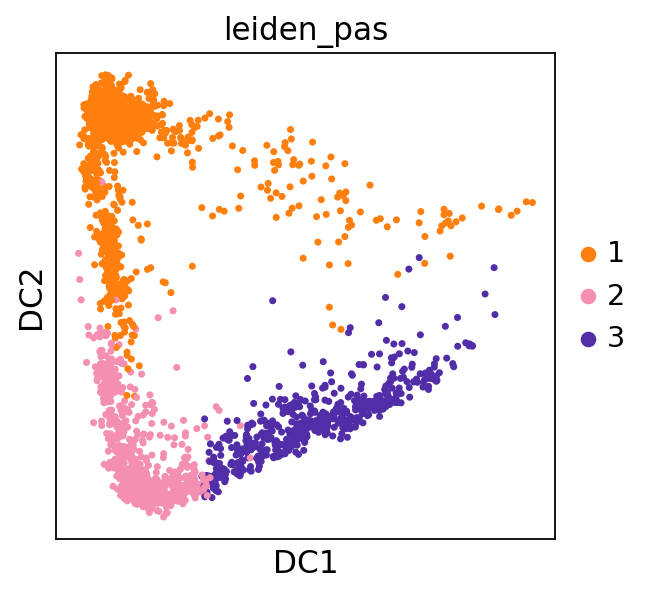

NPPO-2


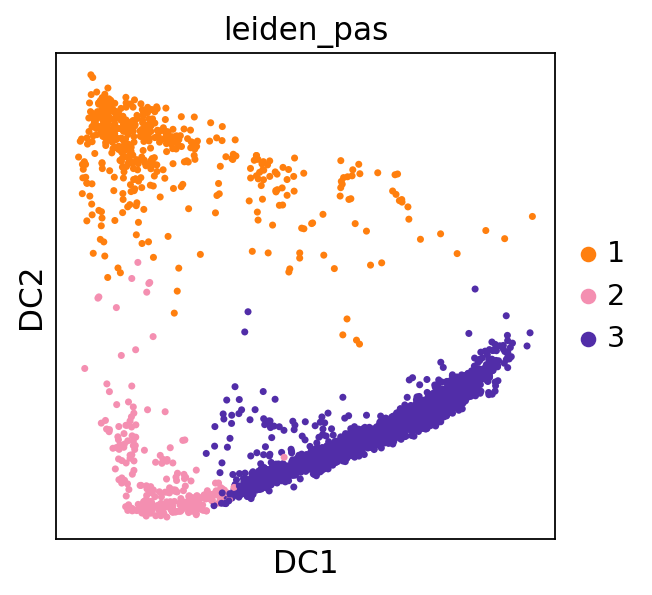

NPPO-4


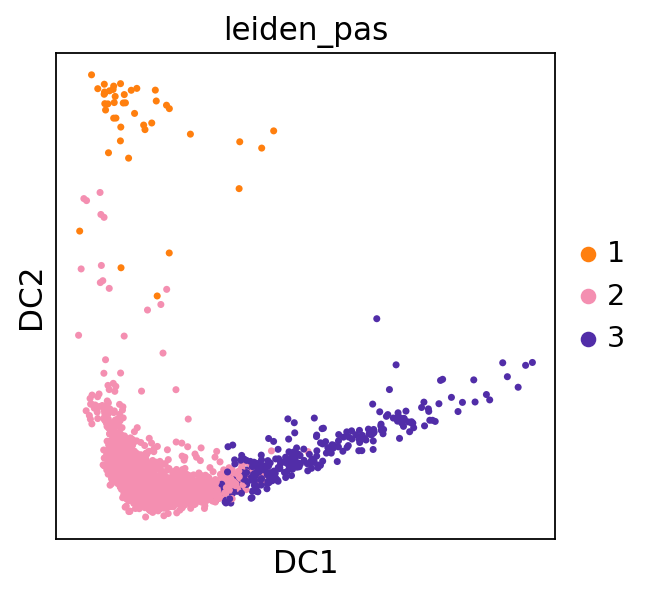

NPPO-1


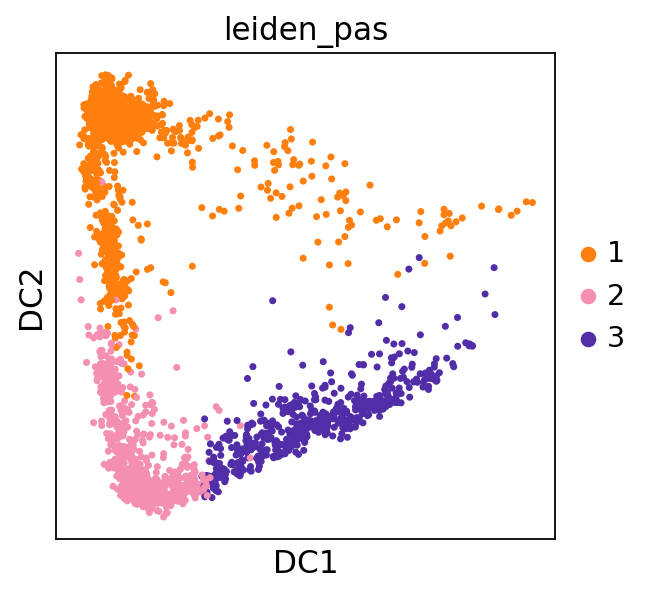

NPPO-6


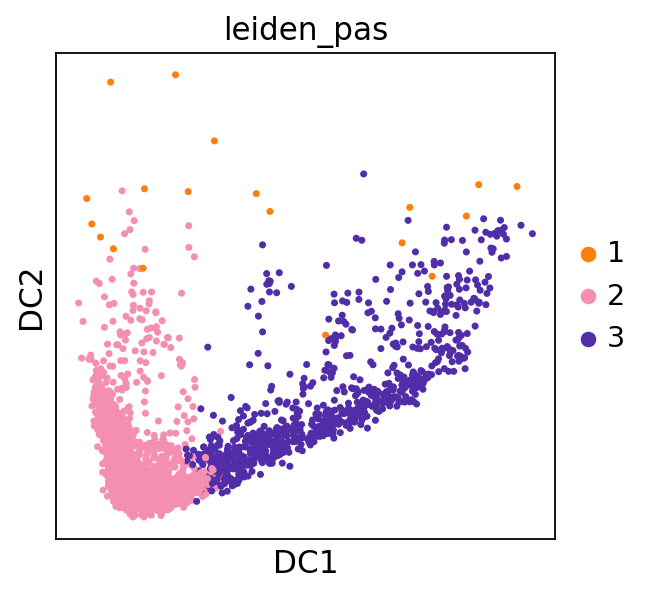

NPPO-5


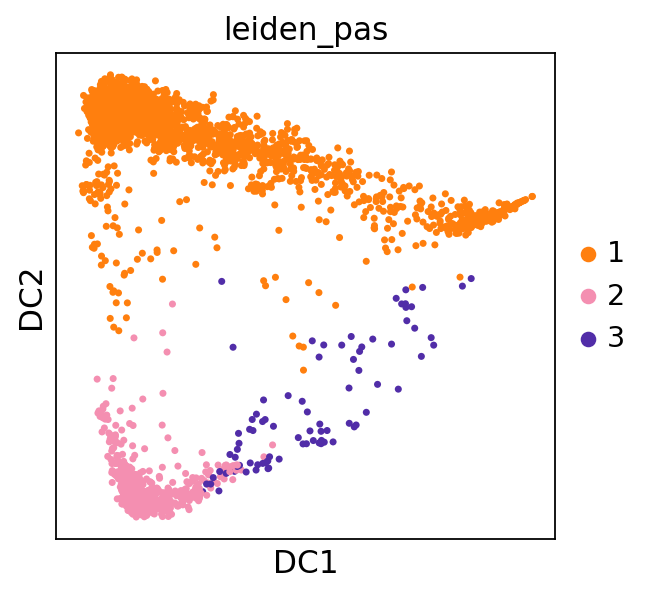

In [45]:
# Plot DiffMap of seprate samples
samples = ["NPPO-1","NPPO-2","NPPO-4","NPPO-1","NPPO-6","NPPO-5"]

for sample_id in samples:
    print(sample_id)
    temp_data = vp_data[vp_data.obs['sample_id_for_paper'] == sample_id].copy()
    
    sc.pl.diffmap(temp_data, color=["leiden_pas"], palette=paper_color_palette)


## Cytotrace Scores

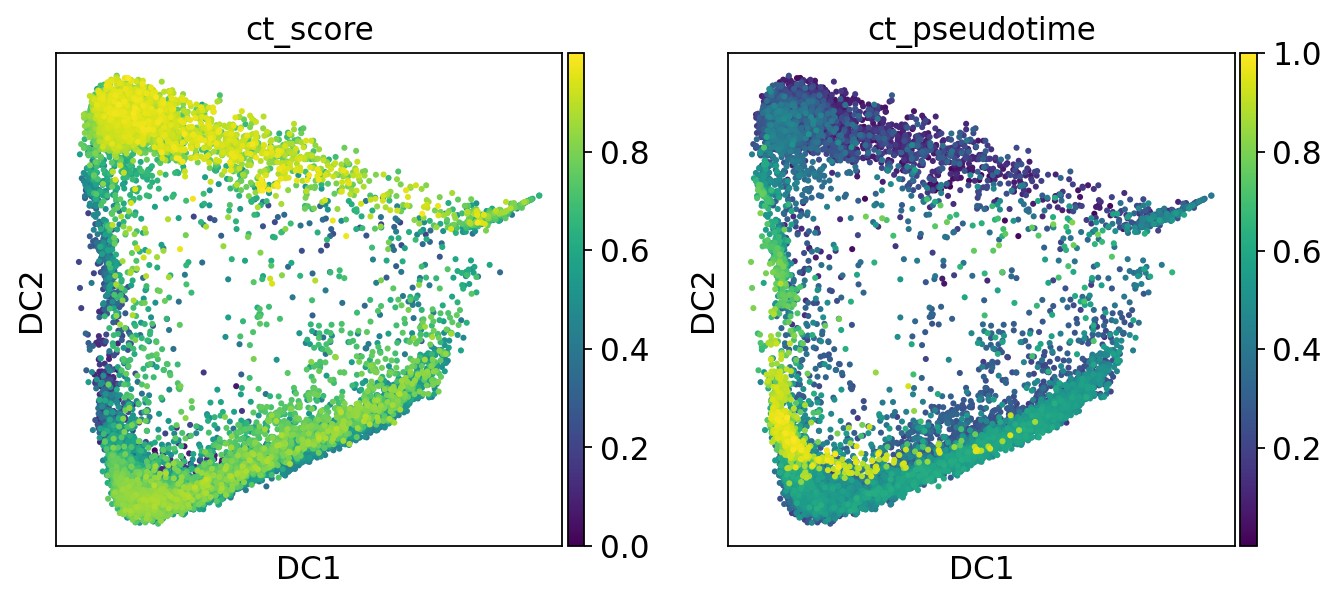

In [ ]:
# Plot the DiffMap with CytoScores
batch = ["NPPO-2","NPPO-4","NPPO-1","NPPO-6","NPPO-5"]
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id_for_paper]
vp_data_sub = vp_data[cells_to_keep]
sc.pl.diffmap(vp_data_sub, color=["ct_score","ct_pseudotime"] , cmap = "viridis" , palette=sc.pl.palettes.default_20 , show=True , return_fig=False , sort_order = True, size = 30 ,
             save='-'+'-'.join(map(str,batch)) + "-samples-diffmap-cytotrace.pdf" )

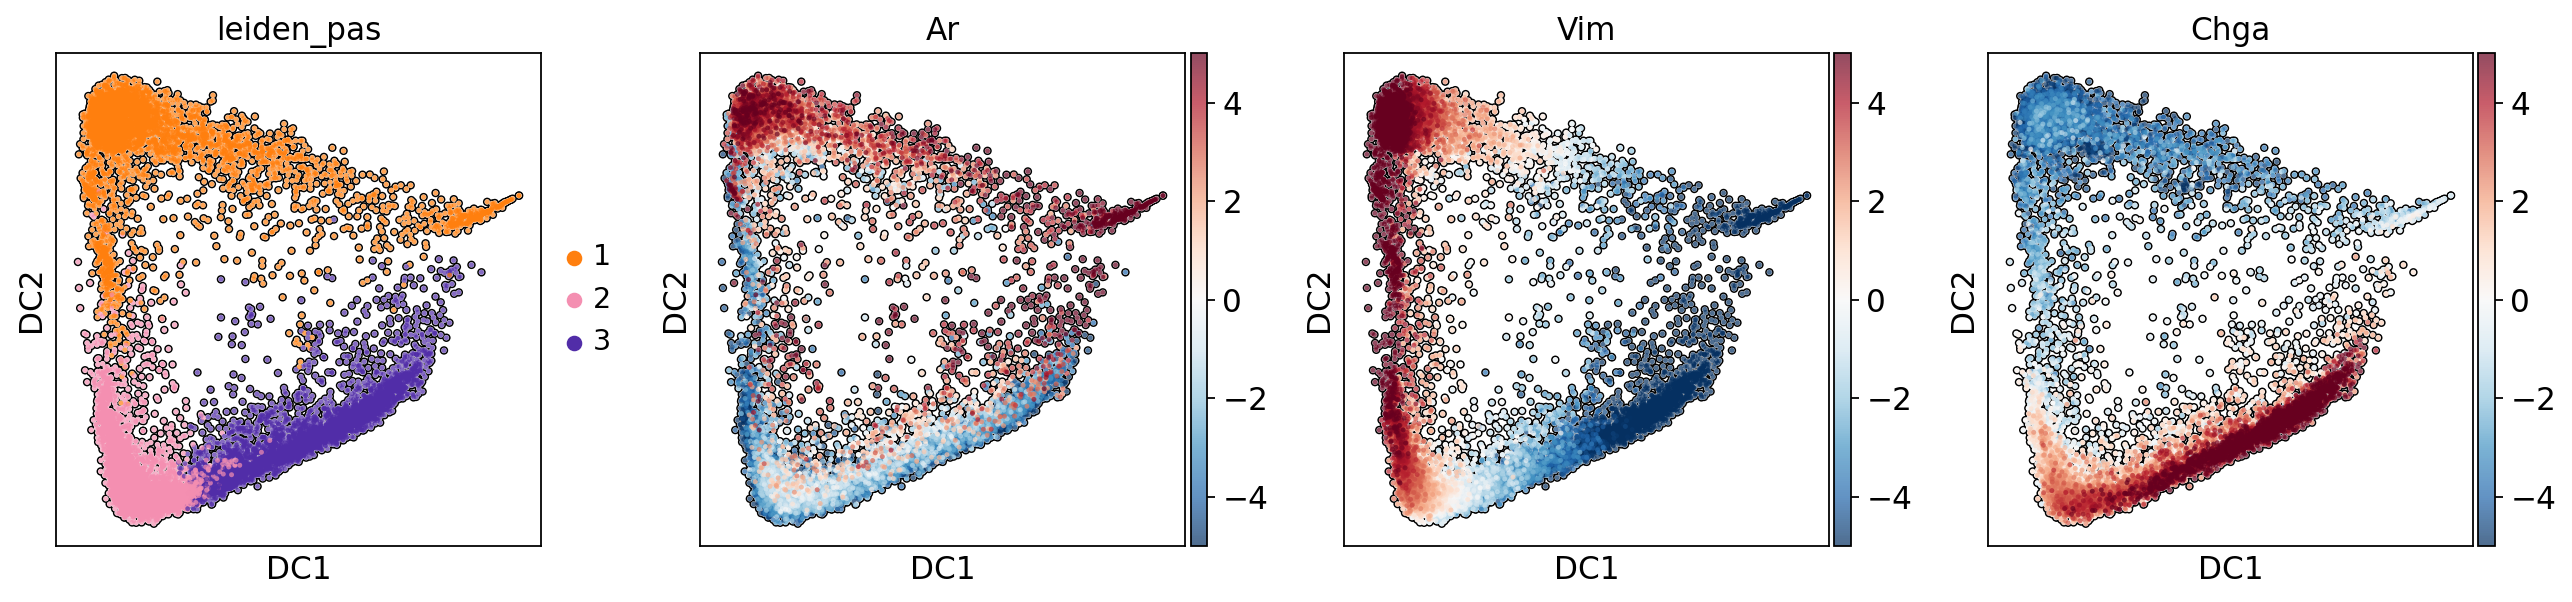

In [ ]:
# Plot DiffMap with leiden clusters and marker genes
sc.settings.set_figure_params(dpi=80,vector_friendly=False)
features = ["leiden_pas","Ar","Vim","Chga"] 
batch = ['MJ002','MJ004','MJ005','MJ007','MJ008']
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id]
vp_data_sub = vp_data[cells_to_keep]
sc.pl.diffmap(vp_data_sub, color=features , palette=paper_color_palette , cmap = "RdBu_r" , vmin = -5 , vmax = 5 , size = 20 , sort_order=True, add_outline=True , show=True , return_fig=False , save='-'.join(map(str,features)) + "-samples-diffmap.pdf" )
sc.settings.set_figure_params(dpi=80,vector_friendly=True)

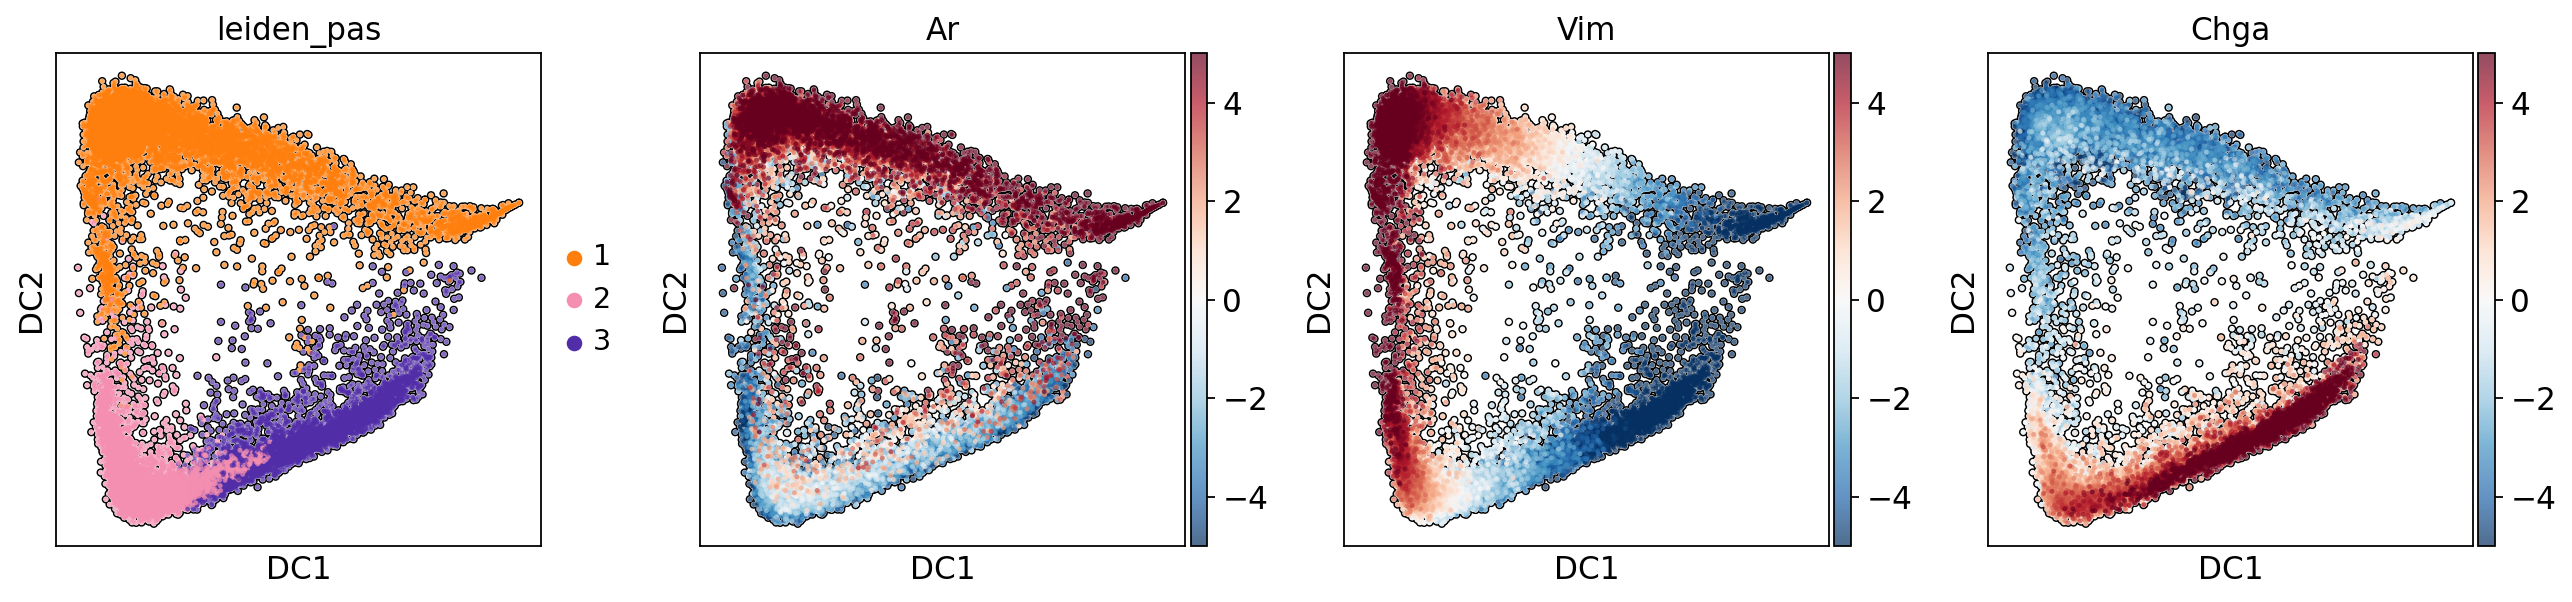

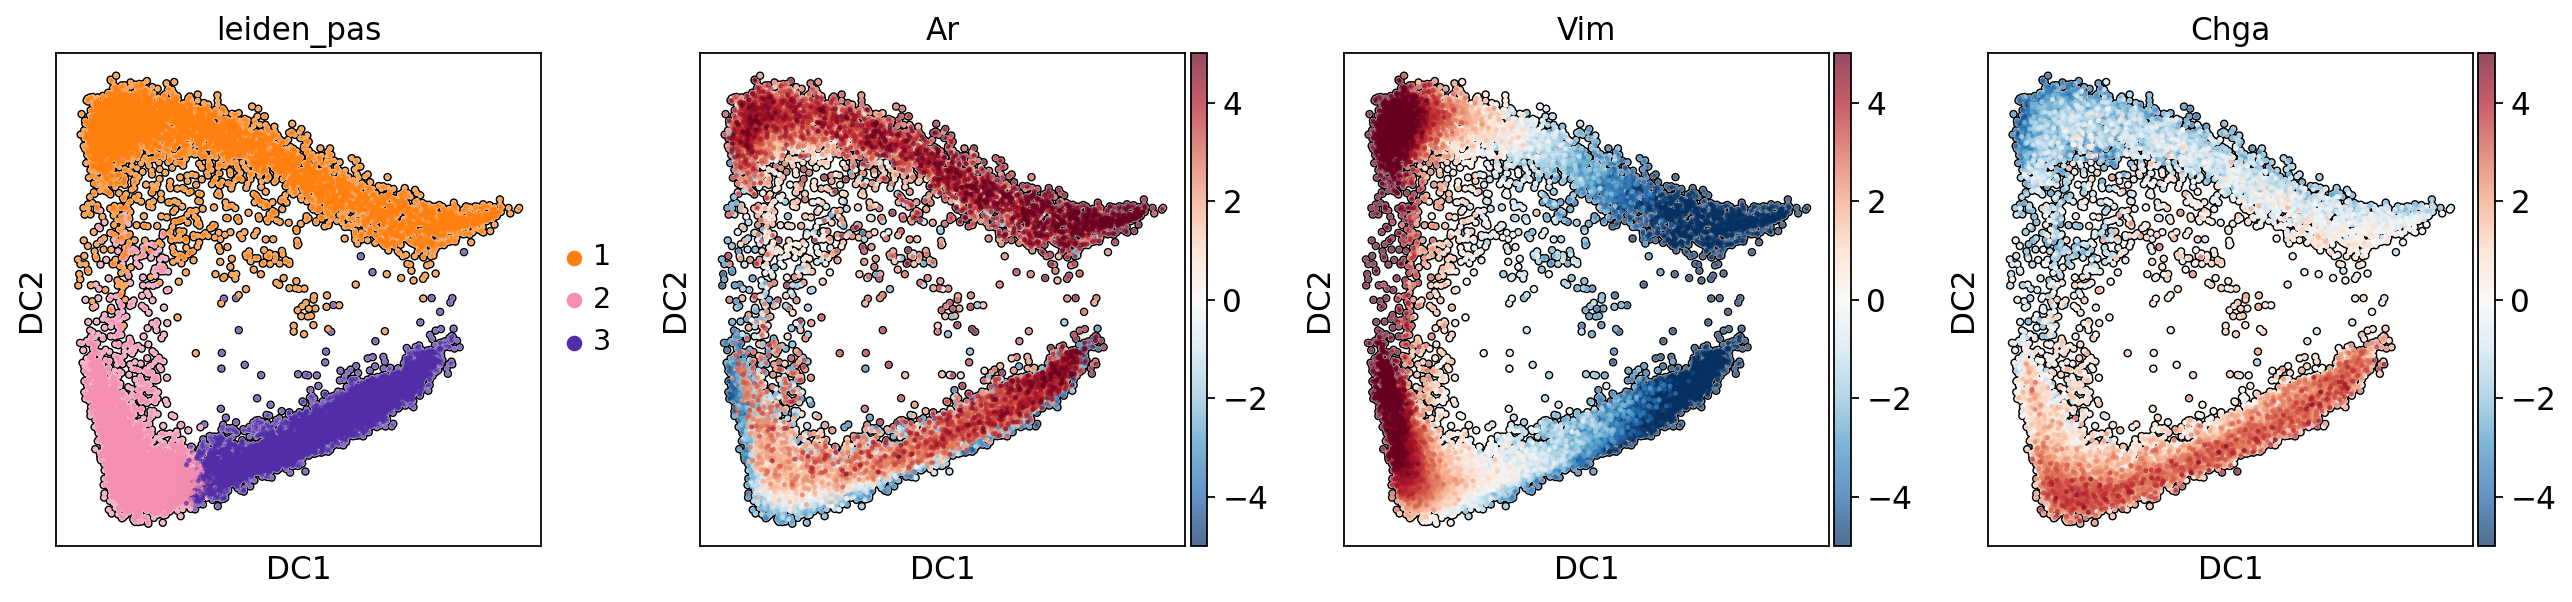

In [13]:
sc.settings.set_figure_params(dpi=80,vector_friendly=False)
features = ["leiden_pas","Ar","Vim","Chga"] 
for batch in ['scRNASeq','snRNASeq']:
    cells_to_keep = [True if x in batch else False for x in vp_data.obs.technology]
    vp_data_sub = vp_data[cells_to_keep]
    sc.pl.diffmap(vp_data_sub, color=features , palette=paper_color_palette , cmap = "RdBu_r" , vmin = -5 , vmax = 5 , size = 20 , sort_order=True, add_outline=True , show=True , return_fig=False , save='-'.join(map(str,features)) + "-samples-diffmap-only-" + batch + ".pdf" )
    # sc.settings.set_figure_params(dpi=80,vector_friendly=True)

In [ ]:
# Set marker genes
marker_genes = ['Ar','Vim','Sox9','Ly6a',
                'Twist1','Snai1','Zeb1','Myc','Hoxb13',
                'Itgb4','Clu','Yap1','Foxa1','Psca','Tmprss2',
                'Fgf1','Fgfr1','Cd44',
                'Nr3c1','Nr3c2','Epcam','Foxa2',
                'Pou3f2',
                'Nsd1','Nsd2','Nsd3',
                'Kdm2a','Onecut2','Nkx3-1','Nkx3.1',
                'Hoxb5','Hoxb6','Dnmt3a','Crebbp','Ep300','Mki67',
                'Chga','Chgb','Syp','Insm1','Ascl1','Neurod1',
                "Ezh2",'Sox2','Mycn']

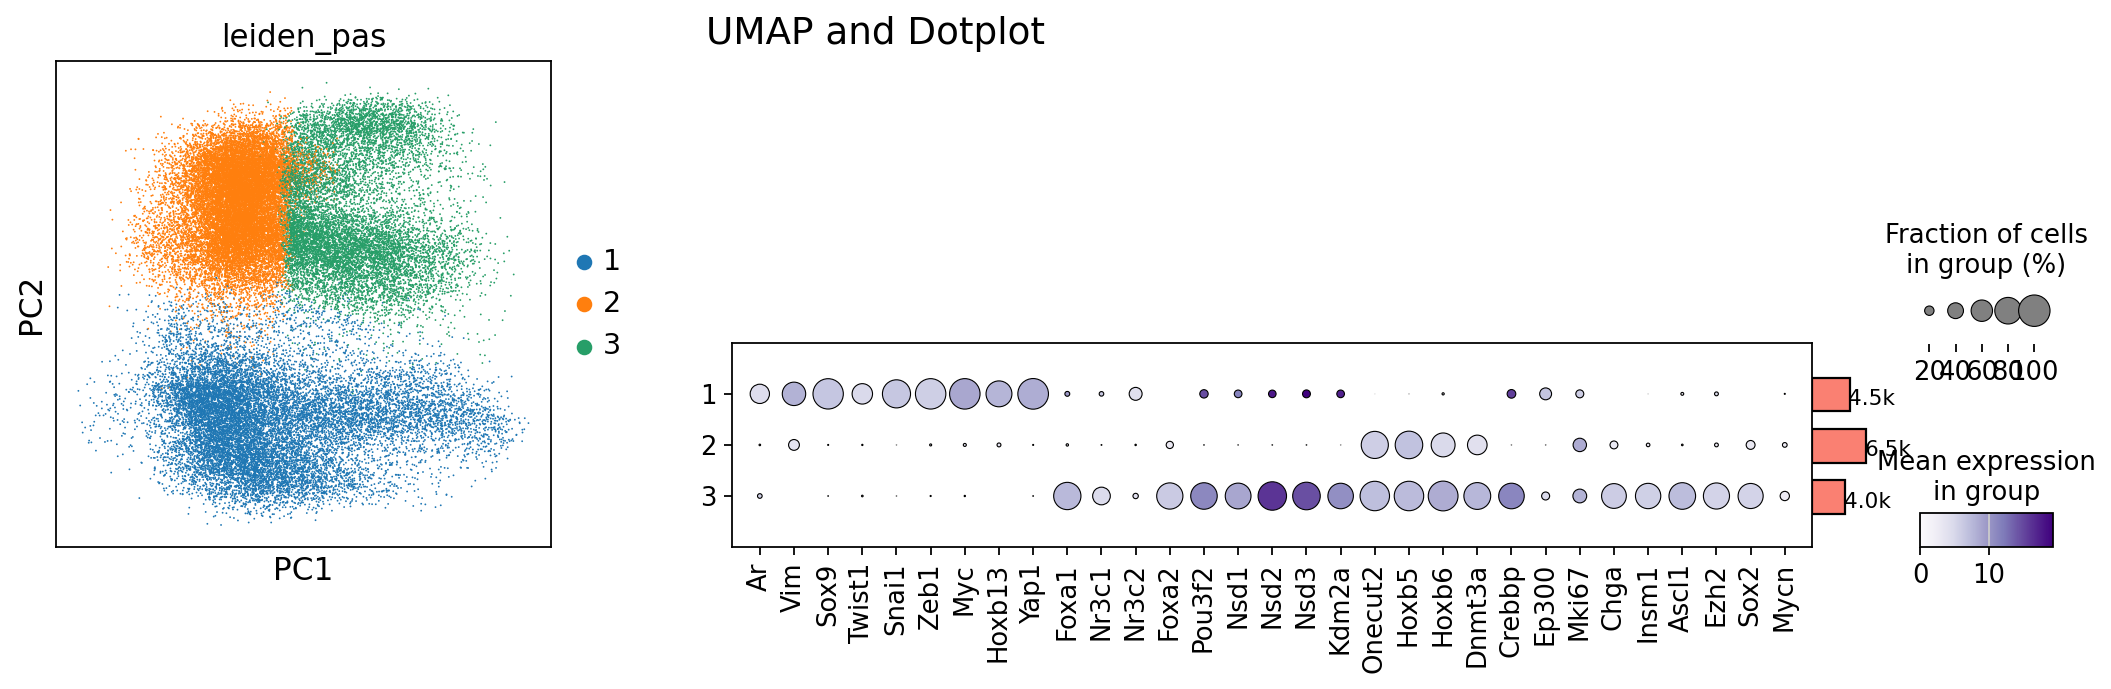

In [ ]:
# Plot UMAP and Dotplot
batch = ['MJ002','MJ004','MJ005','MJ007','MJ008']
cells_to_keep = [True if x in batch else False for x in vp_data.obs.sample_id]
vp_data_sub = vp_data[cells_to_keep]

fig, axs = plt.subplots(1, 2, figsize=(16, 4) , gridspec_kw={'width_ratios': [1.5, 4]})
fig.suptitle(f"UMAP and Dotplot")

sc.pl.pca(vp_data, color=["leiden_pas"] , palette=sc.pl.palettes.default_20 , show=False , return_fig=False , ax = axs[0] )

marker_genes_2 = [x for x in marker_genes if x in vp_data.var_names]

dp = sc.pl.dotplot(vp_data_sub, marker_genes_2, groupby=['leiden_pas'], 
                   layer='mLog10' , cmap="Reds", expression_cutoff=2 ,mean_only_expressed=True, 
                   return_fig=True, ax = axs[1] )

axs[1] = dp.add_totals().style( 
    cmap="Purples",
    dot_edge_color='black', dot_edge_lw=0.5).get_axes()

In [ ]:
# Load cancer hallmarks data
vp_cancer_hallmarks_path = os.path.join(base, "pyviper_h5ad_outputs/human_prot_act.h5ad")
vp_cancer_hallmarks = sc.read_h5ad(vp_cancer_hallmarks_path)
vp_cancer_hallmarks

AnnData object with n_obs × n_vars = 45000 × 50
    obs: 'sample', 'sample_id', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'doublet_score', 'predicted_doublet', 'doublet_info', 'technology', 'ct_score', 'ct_pseudotime', 'ct_num_exp_genes', 'RFP', 'RFP_int', 'sample_pas', 'sample_id_pas', 'n_genes_by_counts_pas', 'total_counts_pas', 'total_counts_mt_pas', 'pct_counts_mt_pas', 'n_genes_pas', 'n_counts_pas', 'doublet_score_pas', 'predicted_doublet_pas', 'doublet_info_pas', 'technology_pas', 'ct_score_pas', 'ct_pseudotime_pas', 'ct_num_exp_genes_pas', 'No.', 'sample_id_for_paper', 'Passage No.', 'categry', 'Note', 'leiden_pas'
    uns: 'gex_data'
    layers: 'mLog10'

In [17]:
vp_cancer_hallmarks.obsm['X_diffmap'] = vp_data.obsm['X_diffmap']
vp_cancer_hallmarks.obs['leiden_pas'] = vp_data.obs['leiden_pas']

/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:484: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(


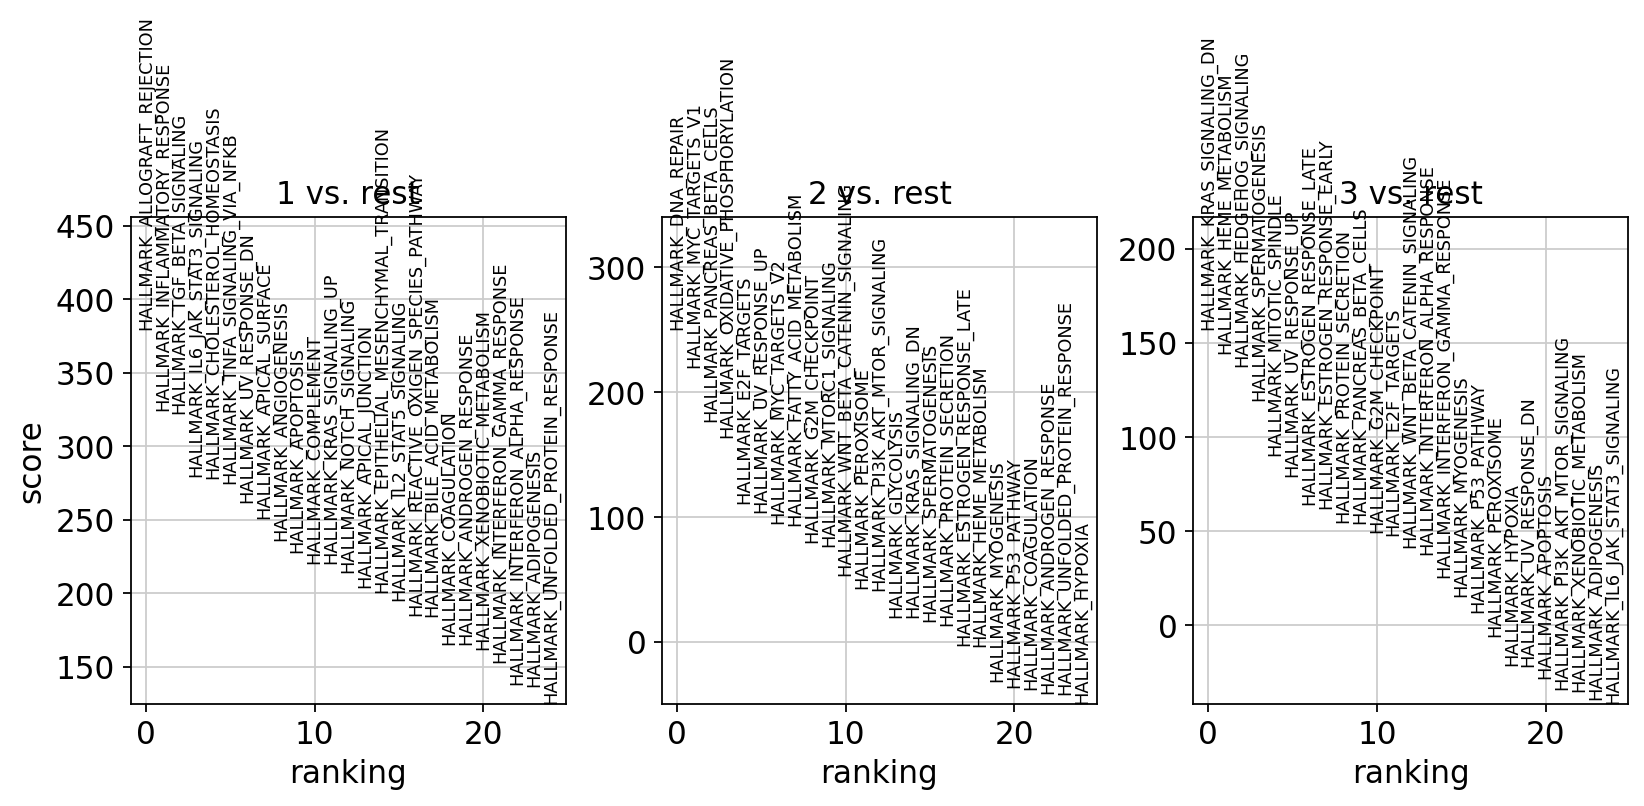

In [ ]:
# Rank the gene groups
vp_cancer_hallmarks_sub = vp_cancer_hallmarks[vp_cancer_hallmarks.obs.technology == "scRNASeq"]
sc.tl.rank_genes_groups(vp_cancer_hallmarks_sub, 'leiden_pas' , method="t-test")
sc.pl.rank_genes_groups(vp_cancer_hallmarks_sub, n_genes=25, sharey=False )

In [19]:
filename = "-Figure-1K.pdf"

batch = ['MJ002','MJ004','MJ005','MJ007','MJ008']
cells_to_keep = [True if x in batch else False for x in vp_cancer_hallmarks_sub.obs.sample_id]
vp_cancer_hallmarks_sub = vp_cancer_hallmarks_sub[cells_to_keep]

1 MJ002_CGGCTAGCAGCTGCTG-1-MJ002-scRNASeq     True
MJ002_GTTAAGCGTAGCGATG-1-MJ002-scRNASeq    False
MJ002_GAGGTGAGTTTGTGTG-1-MJ002-scRNASeq    False
MJ002_GGGACCTTCGCTTGTC-1-MJ002-scRNASeq    False
MJ002_CAGTAACTCCCTGACT-1-MJ002-scRNASeq    False
                                           ...  
MJ008_AATCGACAGTTGTCGT-1-MJ008-scRNASeq     True
MJ008_TAGTGCACAAGGAGTC-1-MJ008-scRNASeq    False
MJ008_CTTCTCTTCCAAGCCG-1-MJ008-scRNASeq     True
MJ008_CTTCTCTTCGGTCAGC-1-MJ008-scRNASeq     True
MJ008_ACTATTCTCACCCTGT-1-MJ008-scRNASeq     True
Name: leiden_pas, Length: 15000, dtype: bool ['HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION', 'HALLMARK_INFLAMMATORY_RESPONSE', 'HALLMARK_NOTCH_SIGNALING', 'HALLMARK_IL6_JAK_STAT3_SIGNALING', 'HALLMARK_TGF_BETA_SIGNALING', 'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_DNA_REPAIR', 'HALLMARK_MYC_TARGETS_V1', 'HALLMARK_G2M_CHECKPOINT', 'HALLMARK_E2F_TARGETS']
All markers are valid var_names!
2 MJ002_CGGCTAGCAGCTGCTG-1-MJ002-scRNASeq    False
MJ002_GTTAAGCGTAGCGATG-

/tmp/ipykernel_86102/4247252371.py:53: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  vp_cancer_hallmarks_sub_reordered.uns[f"{cluster_label}_colors"] = [


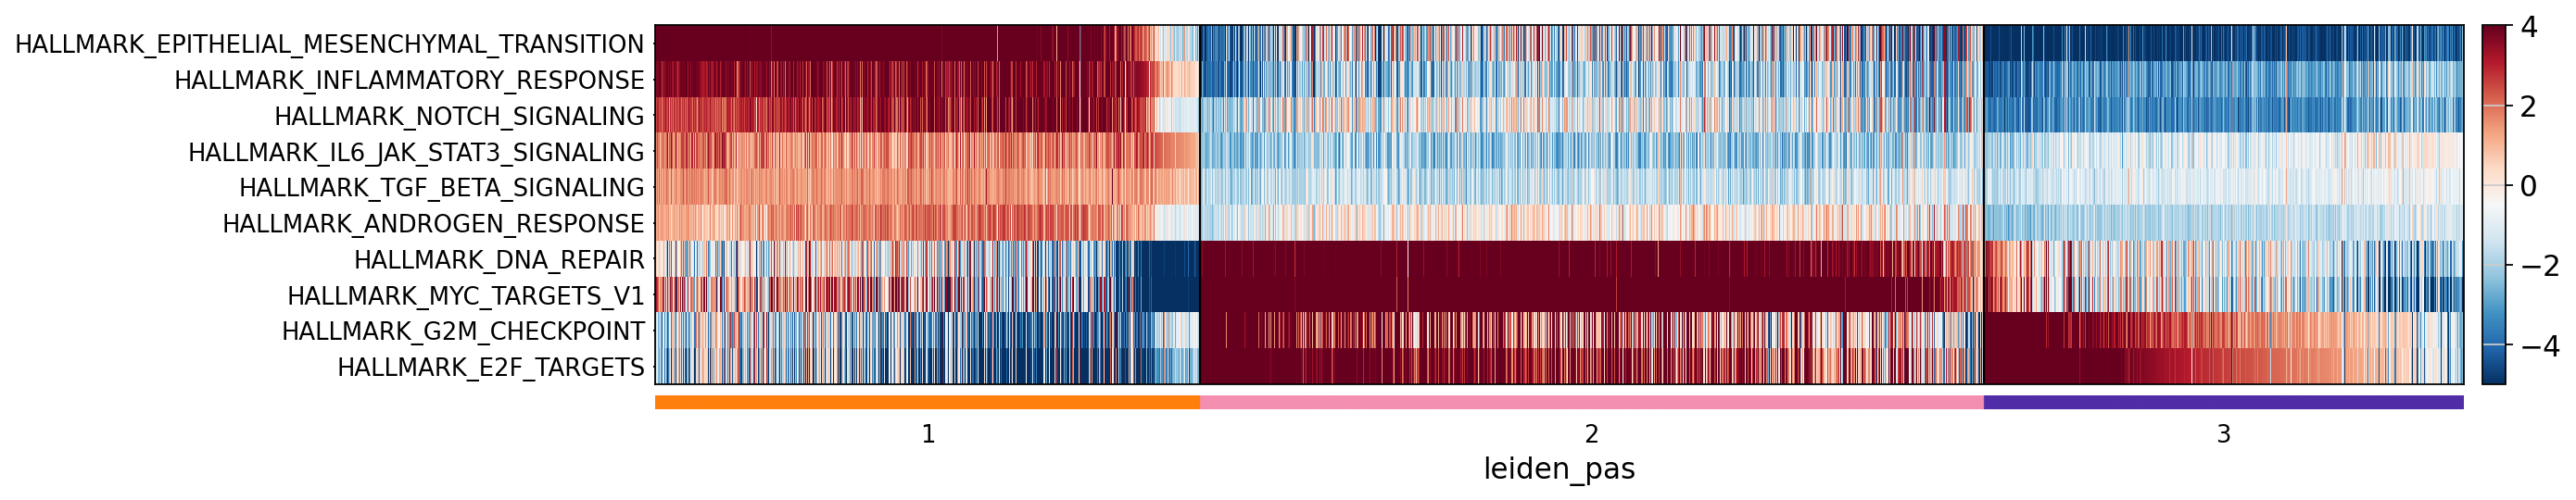

In [20]:
from scipy.cluster.hierarchy import linkage, leaves_list
import numpy as np
import pandas as pd

top_markers = [
    'HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION','HALLMARK_INFLAMMATORY_RESPONSE','HALLMARK_NOTCH_SIGNALING' ,'HALLMARK_IL6_JAK_STAT3_SIGNALING' , 'HALLMARK_TGF_BETA_SIGNALING' ,
    'HALLMARK_ANDROGEN_RESPONSE', 'HALLMARK_DNA_REPAIR','HALLMARK_MYC_TARGETS_V1',"HALLMARK_G2M_CHECKPOINT",'HALLMARK_E2F_TARGETS']

top_markers_reordered = top_markers

# -----------------------------------
# Sort cells within each cluster by mean expression of top markers
# -----------------------------------
clustered_indices = []
cluster_label = "leiden_pas"

for cluster in sorted(vp_cancer_hallmarks_sub.obs[cluster_label].unique()):
    # Get indices of cells in this cluster
    cluster_mask = vp_cancer_hallmarks_sub.obs[cluster_label] == cluster
    print(cluster, cluster_mask, top_markers_reordered)
    # all the feature names currently in your AnnData
    all_vars = set(vp_cancer_hallmarks_sub.var_names)

    # which of your markers aren’t present?
    missing = set(top_markers_reordered) - all_vars

    if missing:
        print("These markers are missing from adata.var_names:")
        for gene in sorted(missing):
            print("  ", gene)
    else:
        print("All markers are valid var_names!")
    cluster_data = vp_cancer_hallmarks_sub[cluster_mask, top_markers_reordered]
    
    # Compute mean expression across markers for each cell
    mean_expression = cluster_data.X.max(axis=1)
    
    # Convert to flat array if needed (depending on sparse/dense)
    if not isinstance(mean_expression, np.ndarray):
        mean_expression = mean_expression.A1 if hasattr(mean_expression, 'A1') else np.array(mean_expression).flatten()

    # Get indices of sorted cells within cluster
    sorted_cell_indices = cluster_data.obs_names[np.argsort(-mean_expression)]
    
    clustered_indices.extend(sorted_cell_indices)

# Reorder AnnData object
vp_cancer_hallmarks_sub_reordered = vp_cancer_hallmarks_sub[clustered_indices, :]

# 1. Get your cluster categories
categories = vp_cancer_hallmarks_sub_reordered.obs[cluster_label].cat.categories
# 2. Assign colors by index (make sure the list has enough colors)
vp_cancer_hallmarks_sub_reordered.uns[f"{cluster_label}_colors"] = [
    paper_color_palette[i] for i in range(len(categories))
]

# Plot
sc.pl.heatmap(
    vp_cancer_hallmarks_sub_reordered, top_markers_reordered, 
    groupby=cluster_label, show_gene_labels=True, cmap="RdBu_r", 
    show=True, use_raw=False, log=False, vmin=-5, vmax=4, 
    dendrogram=False, swap_axes=True, figsize=(16, 3.5), save=filename
)


In [ ]:
# Set the ar target genes
asangani_2014_ar_targets_genes_list = [
    "ABCC4", "ABHD2", "ACSL3", "ADARB2", "AF349445", "AFF4", "AI089002", "AI207522", "AI570240", "AK023660", 
    "AK025360", "AK055915", "AK057576", "AK074291", "AK092594", "AK093002", "AK098478", "AK124281", "AK124426", 
    "AL533190", "AL713762", "ALDH1A3", "AMAC1L2", "ANKRD37", "ANXA2", "ARSG", "ASRGL1", "ATP10A", "ATP1A1", 
    "ATP1A4", "ATRNL1", "AUTS2", "AW029229", "AW389914", "AZGP1", "B3GAT1", "BC039021", "BC041926", "BC041955", 
    "BC055421", "BC062780", "BG462058", "BG618474", "BI710972", "BM469851", "BMPR1B", "BQ017638", "BQ706262", 
    "BRP44", "BU567141", "BU753102", "BX099483", "C10orf114", "C14orf162", "C16orf30", "C18orf1", "C1orf108", 
    "C1orf113", "C1orf26", "C20orf112", "C6orf81", "CA314451", "CA414006", "CBLL1", "CCDC4", "CDC14B", "CDC14C", 
    "CDYL2", "CEBPD", "CENPN", "ChGn", "CHIA", "CHKA", "CHST2", "CLDN12", "CLDN14", "CLDN8", "CTBP1", "CUTL2", 
    "CXorf9", "CYP1A1", "CYP2U1", "DDR2", "DHCR24", "DKFZp761P0423", "DNAJB9", "DOCK11", "DOCK8", "EAF2", "EDG7", 
    "ELL2", "ELOVL5", "ELOVL7", "EMP1", "ENDOD1", "ENST00000358356", "ERN1", "ERRFI1", "F2RL1", "FAM13A1OS", 
    "FER1L3", "FGD4", "FKBP5", "FLJ31568", "FLJ39502", "FRK", "FZD5", "GADD45G", "GIPR", "GREB1", "GSR", "HERC3", 
    "HLA-DRB3", "HOMER2", "HPGD", "HS3ST4", "HSD17B2", "IFI6", "IGF1", "IGF1R", "IL20RA", "IMPAD1", "INPP4B", 
    "KCNMA1", "KLF15", "KLK3", "KLK4", "KLK5", "KRT18", "KRT19", "KRT72", "LAMA1", "LDLR", "LIFR", "LOC205251", 
    "LOC401708", "LOC641467", "LOC646282", "LOC730498", "LONRF1", "LOX", "LRCH1", "LRIG1", "LSS", "MAF", "MAK", 
    "MALT1", "MAP1B", "MAP7D1", "MBOAT2", "MFSD2", "MICAL1", "MLPH", "MOGAT2", "MPZL1", "MTMR9", "NANOGP1", 
    "NAT1", "NCAPD3", "NDFIP2", "NDRG1", "NEBL", "NEK10", "NFKBIA", "NNMT", "NR4A1", "NY-REN-7", "ODC1", "OLAH", 
    "ORM1", "ORM2", "OTUD7B", "PACS1", "PDLIM5", "PECI", "PER1", "PFKFB2", "PGC", "PHACTR3", "PNPLA8", "PPP2CB", 
    "RAB27A", "RAB4A", "RASD1", "RHOU", "RUNX1", "S100A5", "SCRG1", "SGK", "SHROOM3", "SLC16A6", "SLC26A2", 
    "SLC26A3", "SLC2A14", "SLC2A3", "SLC38A4", "SLC41A1", "SLC45A3", "SLITRK6", "SMC4", "SMOC1", "SNAI2", 
    "SNTG2", "SOCS2", "SPDEF", "SPDYA", "SPINK5L3", "SPOCK1", "SPTB", "ST6GALNAC1", "STEAP4", "STK17B", "TACC1", 
    "TBRG1", "TBX15", "TG", "TGFB2", "TIPARP", "TLOC1", "TMCC3", "TMPRSS2", "TNFAIP3", "TPD52", "TRIM36", "TRIM63", 
    "TTN", "TUBA3D", "WIPI1", "WNT7B", "WWTR1", "X03757", "ZBTB1", "ZBTB16", "ZBTB24"
]

In [ ]:
# Load adatas
sc_adata_ges_path = os.path.join(base, "adata_h5ad_outputs/adata_scRNASeq.h5ad")
sc_adata_ges = sc.read_h5ad(sc_adata_ges_path)
sn_adata_ges_path = os.path.join(base, "adata_h5ad_outputs/adata_snRNASeq.h5ad")
sn_adata_ges = sc.read_h5ad(sn_adata_ges_path)

In [23]:
sc_adata_ges.obs["RFP"] = [ 1 if i > 0 else 0 for i in sc_adata_ges[:,"addgene26001"].X ]
sc_adata_ges.obs["RFP_int"] = sc_adata_ges.obs["RFP"]
sc_adata_ges.obs["RFP"] = sc_adata_ges.obs["RFP"].astype("category")

In [ ]:
# Concatenate the gene expressions
adata_ges = sc_adata_ges.concatenate(
    sn_adata_ges,
    batch_categories=["scRNASeq","snRNASeq"],
    batch_key="technology",
    uns_merge="unique",
    join='outer',
    fill_value=0
)

adata_ges.obs = adata_ges.obs.join( vp_data.obs  , lsuffix = "_ges" )
adata_ges.obsm['X_diffmap'] = vp_data.obsm['X_diffmap']

/tmp/ipykernel_86102/2664922040.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_ges = sc_adata_ges.concatenate(


In [ ]:
# Create the interactome for the pyviper run
df = pd.DataFrame()
df['regulator'] = ['AR_Asangani_2014'] * len(asangani_2014_ar_targets_genes_list)
df['target'] = asangani_2014_ar_targets_genes_list
df['mor'] = 1
df['likelihood'] = 1
asangani_interactome = pyviper.Interactome(net_table=df,name="asangani-2024")

In [28]:
adata_ges_human = copy.deepcopy(adata_ges)

In [ ]:
# Keep only snRNASeq cells
batch = ['snRNASeq']
cells_to_keep = [True if x in batch else False for x in adata_ges_human.obs.technology]
adata_ges_human = adata_ges_human[cells_to_keep]

In [ ]:
# Translate from mouse to hhuman symbols
pyviper.pp.translate(adata_ges_human, desired_format = "human_symbol")
asangani_interactome.filter_targets(adata_ges_human.var_names)

/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/pyviper/_translate.py:138: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var[current_format] = adata.var.index.values.astype(str)
/home/gaizenman/anaconda3/envs/my_env/lib/python3.12/site-packages/pyviper/_translate.py:26: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  gene = str(input_array[i])


Removed 80 targets.


In [ ]:
# Run Pyviper
adata_enr = pyviper.viper( adata_ges_human , asangani_interactome , enrichment="area" , eset_filter = False , verbose = False)

In [32]:
batch = ['snRNASeq']
cells_to_keep = [True if x in batch else False for x in vp_data.obs.technology]
vp_data_sub = vp_data[cells_to_keep]
adata_enr.obsm["X_diffmap"] = vp_data_sub.obsm["X_diffmap"]

In [ ]:
adata_enr.layers['mLog10'] = -1*np.log10(norm.sf( adata_enr.X ))

NPPO-6-H3.3K36M


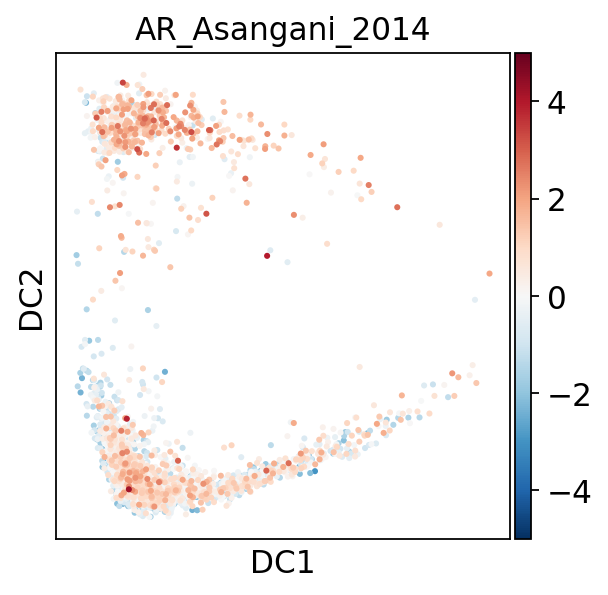

NPPO-6-EV


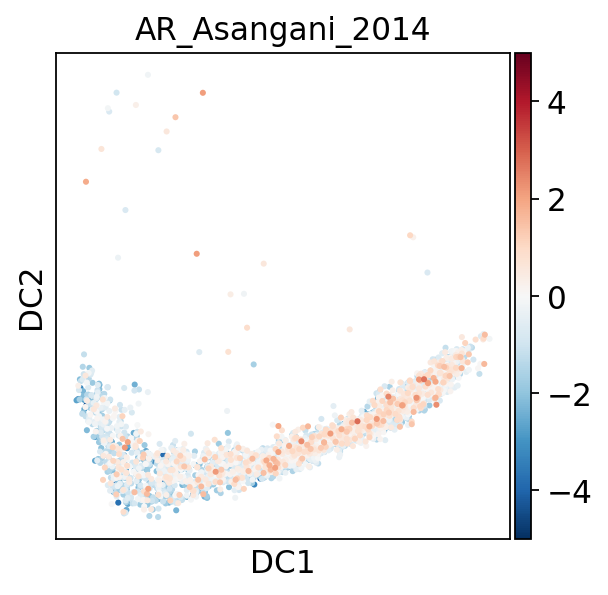

NPPO-2-SgNSD2


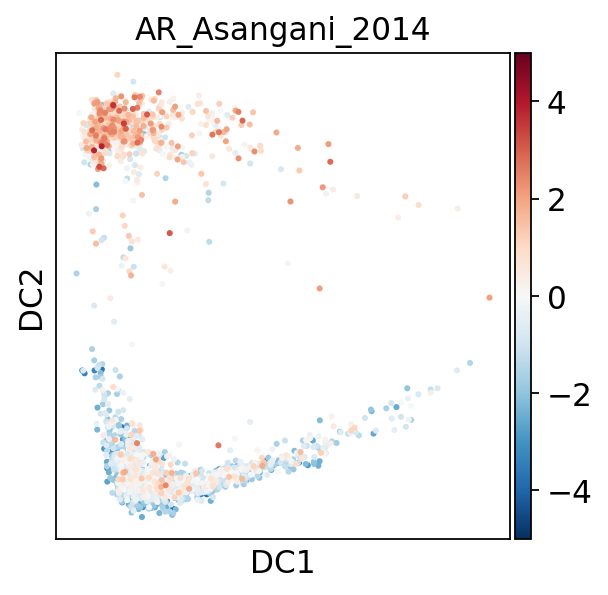

NPPO-2-SgControl


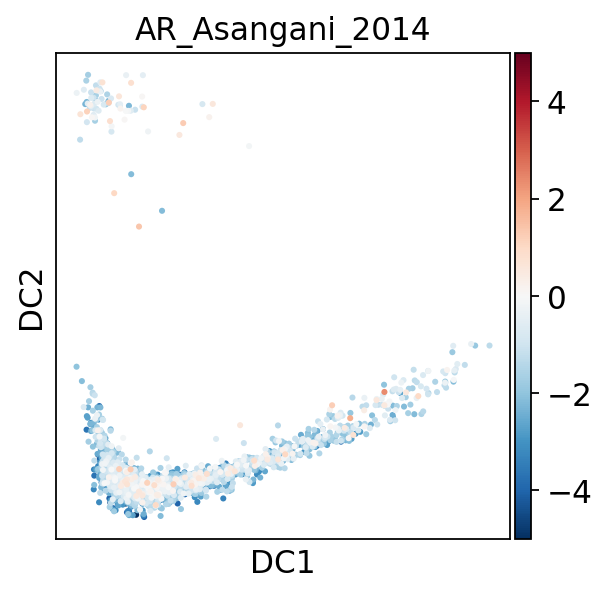

NPPO-1NE-SgNSD2


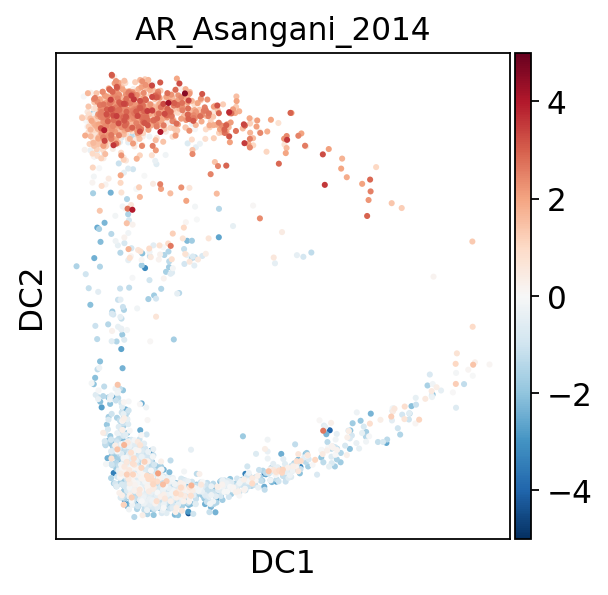

NPPO-1NE-SgControl


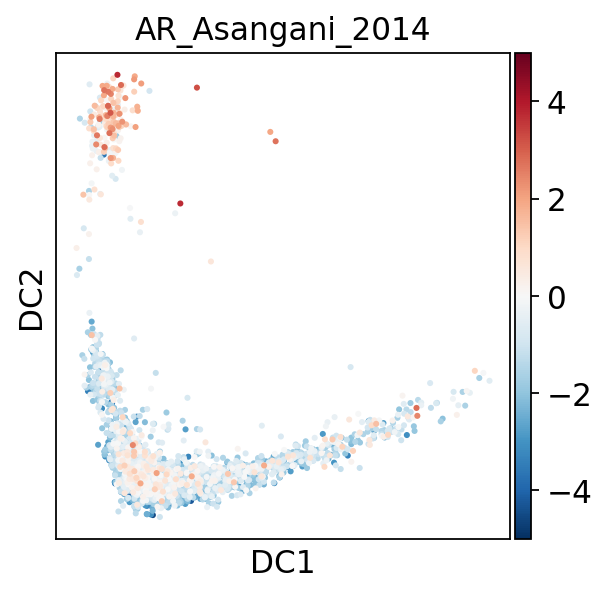

NPPO-1NE_DMSO


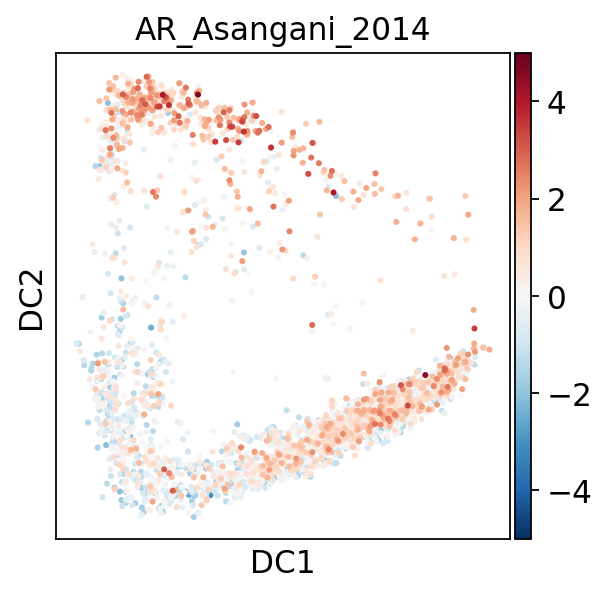

NPPO-1NE_KTX-1001


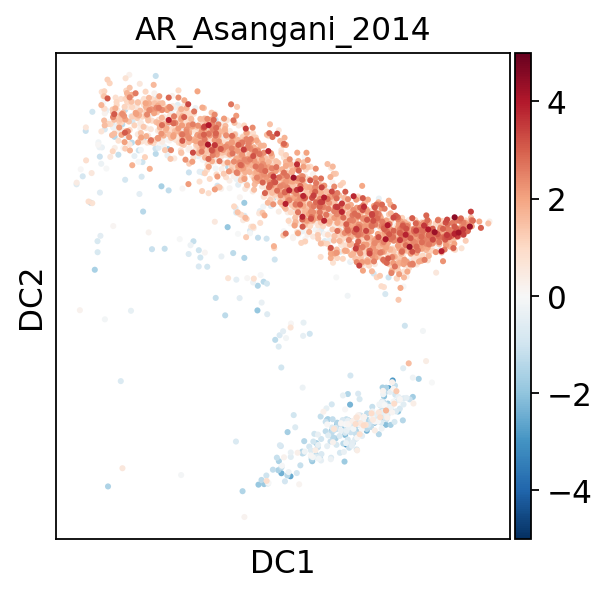

In [ ]:
# Plot the AR targets on a Diffmap for each sample
for sample in adata_enr.obs['sample_id_for_paper'].unique():
    print(sample)
    batch = [sample]
    cells_to_keep = [True if x in batch else False for x in adata_enr.obs.sample_id_for_paper]
    adata_enr_sub = adata_enr[cells_to_keep]

    filename = f"-AR-targets-{sample}.pdf"
    sc.pl.diffmap(adata_enr_sub, color=['AR_Asangani_2014'],
                  size=30, alpha=1, ncols=4,
                  cmap="RdBu_r", vmin=-5, vmax=5, wspace=0.5,
                  sort_order=True,
                  show=True,
                  save=filename)